In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [56]:
def age_format(age):
    if 18 <= age <= 24:
        return 1
    elif 25 <= age <= 34:
        return 2
    elif 35 <= age <= 44:
        return 3
    elif 45 <= age <= 54:
        return 4
    elif age >= 55:
        return 5
    else: 
        return 0
    
train_cat_subcat = pd.read_excel('Test case - Regression.xlsx').drop('Unnamed: 0', axis =1)
train_cat_subcat.loc[:,  ['Gender']] = train_cat_subcat.loc[:,  ['Gender']].replace({'Female':1,'Male':0})
train_cat_subcat['Gender'].astype(int)
train_cat_subcat = pd.get_dummies(train_cat_subcat, columns=['Gender'])
train_cat_subcat['Age'] = train_cat_subcat['Age'].map(lambda x: age_format(x) )
train_cat_subcat = pd.get_dummies(train_cat_subcat, columns=['Age'])

train_cat_subcat =train_cat_subcat[['Gender_0', 'Gender_1', 'Age_2', 'Age_3',
       'Age_4', 'Age_5', 'Income', 'KASKO_flg']]


train_cat_subcat.head()

,Gender_0,Gender_1,Age_2,Age_3,Age_4,Age_5,Income,KASKO_flg
0,0,1,0,0,1,0,30000,0
1,1,0,0,1,0,0,135000,0
2,1,0,0,1,0,0,70000,0
3,0,1,1,0,0,0,127000,0
4,1,0,0,0,1,0,125000,0


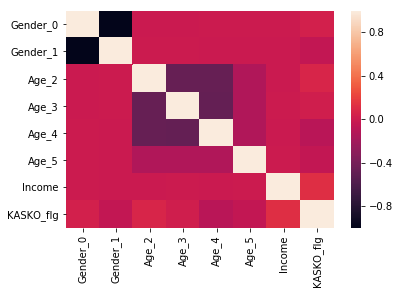

In [57]:
sns.heatmap(train_cat_subcat.corr())

In [58]:
train_cat_subcat.columns

Index(['Gender_0', 'Gender_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Income',
       'KASKO_flg'],
      dtype='object')

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [59]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

In [75]:
df_X = train_cat_subcat.drop('KASKO_flg', axis =1).values
df_y = train_cat_subcat['KASKO_flg'].values.reshape(-1,1)

X_train, X_test, y_train, y = train_test_split(df_X, df_y, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (26800, 7)
X_test  (13200, 7)


In [62]:
scores = []
n_est =  [1, 10, 20, 50, 100]

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())])

for n in n_est:
    model = BaggingClassifier(base_estimator=base_model, 
                              n_estimators=n, 
                              bootstrap_features=False, n_jobs=1)
    scores.append(cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1).mean())
print(scores)    

[0.6040532604302223, 0.6039524747507246, 0.6042667263866784, 0.6040552774917683, 0.6040576053417035]


In [76]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

param_grid = {
    'criterion': ['gini'], #критерии
    'max_depth': randint(2, 8), #максимальная глубина от 2 до 8
    'min_samples_leaf': randint(3, 10), #минимальное количество объектов в вершие дерева, достаточное чтоб дробить дерево на части
    'class_weight': [None, 'balanced']} #объекты классов, которые недопредставлены в выборке, будет взвешивать и балансировать

# Некоторые параметры мы задали не простым перечислением значений, а с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model4 = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model4, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123) #200 переборов, n_jobs=-1 дает параллельное вычисление
# А дальше, просто .fit()
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'criterion': ['gini'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11ddc6be0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11ddc6c88>, 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [77]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

model4best = random_search.best_estimator_

predict = model4best.predict(X_test)                      # делаем предсказание
print('#'*10,'>>> DecisionTreeClassifier random_search <<<','#'*10,'\n',classification_report(y, predict),'\n')

cross4 = cross_val_score(model4best,df_X,df_y,scoring='roc_auc', cv=10)

print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
      '\nmodel4. DecisionTreeClassifier random_search \t{:.4f}'
      .format( (sum(cross4) / float(len(cross4))) ) )

########## >>> DecisionTreeClassifier random_search <<< ########## 
               precision    recall  f1-score   support

           0       0.77      0.58      0.66      8866
           1       0.43      0.64      0.51      4334

   micro avg       0.60      0.60      0.60     13200
   macro avg       0.60      0.61      0.59     13200
weighted avg       0.66      0.60      0.61     13200
 

########## >>> AVG roc_auc for Train: <<< ########## 
model4. DecisionTreeClassifier random_search 	0.6530


In [95]:
train_cat_subcat_predict = train_cat_subcat.reset_index().merge(
    (pd.DataFrame(model4best.predict_proba(df_X))).reset_index(),
    on = 'index'
).sort_values(1, ascending = False)

train_cat_subcat_predict.head()

,index,Gender_0,Gender_1,Age_2,Age_3,Age_4,Age_5,Income,KASKO_flg,0,1
3865,3865,1,0,1,0,0,0,89000,0,0.311094,0.688906
15182,15182,1,0,1,0,0,0,59000,0,0.311094,0.688906
27123,27123,1,0,1,0,0,0,155000,1,0.311094,0.688906
4653,4653,1,0,1,0,0,0,162000,0,0.311094,0.688906
27134,27134,1,0,1,0,0,0,65000,1,0.311094,0.688906


In [96]:
train_cat_subcat_predict[train_cat_subcat_predict['Gender_1'] == 1]

,index,Gender_0,Gender_1,Age_2,Age_3,Age_4,Age_5,Income,KASKO_flg,0,1
37776,37776,0,1,0,0,0,1,64000,0,0.374964,0.625036
17957,17957,0,1,0,0,0,1,101000,1,0.374964,0.625036
37532,37532,0,1,0,0,0,1,114000,1,0.374964,0.625036
36585,36585,0,1,0,0,0,1,76000,1,0.374964,0.625036
5903,5903,0,1,0,0,0,1,64000,0,0.374964,0.625036
12262,12262,0,1,0,0,0,1,120000,0,0.374964,0.625036
21717,21717,0,1,0,0,0,1,76000,1,0.374964,0.625036
21816,21816,0,1,0,0,0,1,66000,0,0.374964,0.625036
15868,15868,0,1,0,0,0,1,112000,0,0.374964,0.625036
21708,21708,0,1,0,0,0,1,99000,0,0.374964,0.625036


In [97]:
train_cat_subcat_predict[train_cat_subcat_predict['Gender_0'] == 1]

,index,Gender_0,Gender_1,Age_2,Age_3,Age_4,Age_5,Income,KASKO_flg,0,1
3865,3865,1,0,1,0,0,0,89000,0,0.311094,0.688906
15182,15182,1,0,1,0,0,0,59000,0,0.311094,0.688906
27123,27123,1,0,1,0,0,0,155000,1,0.311094,0.688906
4653,4653,1,0,1,0,0,0,162000,0,0.311094,0.688906
27134,27134,1,0,1,0,0,0,65000,1,0.311094,0.688906
27137,27137,1,0,1,0,0,0,60000,0,0.311094,0.688906
27138,27138,1,0,1,0,0,0,61000,0,0.311094,0.688906
4646,4646,1,0,1,0,0,0,148000,0,0.311094,0.688906
27155,27155,1,0,1,0,0,0,166000,0,0.311094,0.688906
27158,27158,1,0,1,0,0,0,116000,0,0.311094,0.688906
